In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import subprocess
import warnings
import re
import glob
import networkx as nx

import semopy
from semopy import Model
#import graphviz
import statsmodels.api as sm
from scipy import stats
from scipy.linalg import cholesky, LinAlgError

python_exe = "/opt/homebrew/Caskroom/miniconda/base/envs/ldsc_env/bin/python"
munge_script = "/Users/apple/ldsc-2.0.1/munge_sumstats.py"
ldsc_script = "/Users/apple/ldsc-2.0.1/ldsc.py"

hw4_path = "../HW/HW4"
snp_list_path = f"{hw4_path}/ldsc_inputs/w_hm3.snplist"
reference_ld_path = f"{hw4_path}/ldsc_inputs/for_h2/eur_w_ld_chr/"

fmt_sumstats = "data/formatted_sumstats"
genetic_correlation_results_folder = "data/genetic_correlation_results"
heritability_results_folder = "data/heritability_results"

os.makedirs(fmt_sumstats, exist_ok=True)
os.makedirs(heritability_results_folder, exist_ok=True)
os.makedirs(genetic_correlation_results_folder, exist_ok=True)

traits = [
    "age_at_first_birth",
    "cannabis_dependence",
    "chronotype",
    "income",
    "number_of_children_born",
    "ptsd",
    "sporadic_miscarriage"
]

In [42]:
def parse_genetic_correlation_results(path=genetic_correlation_results_folder, traits=traits):

    pattern_gc = re.compile(
        r"Genetic Correlation:\s*([-\d.eE]+)\s*\(\s*([-\d.eE]+)\s*\)"
    )
    pattern_z  = re.compile(r"Z-score:\s*([-\d.eE]+)")
    pattern_p  = re.compile(r"P:\s*([-\d.eE]+)")

    records = []
    files = glob.glob(os.path.join(path, "*_rg.log"))

    # Remove _rg and .log from filenames
    for fn in files:
        base = os.path.basename(fn)
        name = base[:-4]           
        if name.endswith("_rg"):
            name = name[:-3]     

        # match trait1, trait2
        t1 = t2 = None
        for trait in traits:
            prefix = trait + "_"
            if name.startswith(prefix):
                cand = name[len(prefix):]
                if cand in traits:
                    t1, t2 = trait, cand
                    break
                
        # reverse the order
        if t1 is None:
            for trait in traits:
                suffix = "_" + trait
                if name.endswith(suffix):
                    cand = name[:-len(suffix)]
                    if cand in traits:
                        t1, t2 = cand, trait
                        break
        if t1 is None:
            raise ValueError(f"cant obtain trait1/trait2: {base}")

        # Read rg, se, z, p
        rg = se = z = p = None
        with open(fn, 'r') as fh:
            for line in fh:
                line = line.strip()
                m = pattern_gc.match(line)
                if m:
                    rg = float(m.group(1))
                    se = float(m.group(2))
                    continue
                m = pattern_z.match(line)
                if m:
                    z = float(m.group(1))
                    continue
                m = pattern_p.match(line)
                if m:
                    p = float(m.group(1))
                    continue

        records.append({
            'trait1': t1,
            'trait2': t2,
            'rg':      rg,
            'se':      se,
            'z':       z,
            'p':       p
        })

    df = pd.DataFrame(records,
                      columns=['trait1','trait2','rg','se','z','p'])
    return df

In [43]:
def extract_heritability_results():
    h2_results = {}
    
    for trait in traits:
        result_file = f"{heritability_results_folder}/{trait}.log"
        
        try:
            with open(result_file, 'r') as f:
                lines = f.readlines()
                for line in lines:
                    if "h2:" in line:
                        print(f"Debug - Found h2 line in {trait}: {line.strip()}")
                        
                    if "Total Observed scale h2:" in line:
                        try:
                            parts = line.strip().split(":")[1].strip().split("(")[0].strip()
                            h2 = float(parts)
                            
                            se_part = line.strip().split("(")[1].split(")")[0] if "(" in line else "0.0"
                            se = float(se_part) if se_part.replace('.','',1).isdigit() else 0.0
                            
                            h2_results[trait] = {'h2': h2, 'se': se}
                            break
                        except Exception as e:
                            print(f"Error parsing h2 for {trait}: {e}")
                            print(f"Problematic line: {line}")
        except FileNotFoundError:
            print(f"Warning: Heritability results for {trait} not found")
            
            # if trait == "sporadic_miscarriage":
            #     h2_results[trait] = {'h2': 0.0026, 'se': 0.0007}
            # elif trait == "age_at_first_birth":
            #     h2_results[trait] = {'h2': 0.25, 'se': 0.02}
            # elif trait == "number_of_children_born":
            #     h2_results[trait] = {'h2': 0.15, 'se': 0.02}
            # elif trait == "cannabis_dependence":
            #     h2_results[trait] = {'h2': 0.12, 'se': 0.03}
            # elif trait == "ptsd":
            #     h2_results[trait] = {'h2': 0.10, 'se': 0.025}
            # else:
            #     h2_results[trait] = {'h2': 0.10, 'se': 0.02}
    
    return pd.DataFrame.from_dict(h2_results, orient='index')

In [44]:
def build_sem_spec(traits):
    reproductive_traits = ['age_at_first_birth', 'number_of_children_born']
    psychiatric_traits   = ['cannabis_dependence', 'ptsd']
    environmental_traits = ['chronotype', 'income']

    spec  = "# measurement model\n"
    spec += "ReproductiveFactor =~ " + " + ".join(
        t for t in reproductive_traits if t in traits
    ) + "\n"
    spec += "PsychiatricFactor =~ " + " + ".join(
        t for t in psychiatric_traits if t in traits
    ) + "\n"
    spec += "EnvironmentalFactor =~ " + " + ".join(
        t for t in environmental_traits if t in traits
    ) + "\n\n"

    spec += "# structural model\n"

    spec += "sporadic_miscarriage ~ " + " + ".join([
        fac for fac in ["ReproductiveFactor", "PsychiatricFactor", "EnvironmentalFactor"]
        if any(fac.startswith(prefix) for prefix in ["ReproductiveFactor","PsychiatricFactor","EnvironmentalFactor"])
    ]) + "\n\n"

    spec += "# factor correlations\n"
    spec += "ReproductiveFactor ~~ PsychiatricFactor\n"
    spec += "ReproductiveFactor ~~ EnvironmentalFactor\n"
    spec += "PsychiatricFactor ~~ EnvironmentalFactor\n"

    return spec

In [45]:
def build_genetic_covariance_matrix(gc_df, h2_df, traits):
    SIGMA = pd.DataFrame(0.0, index=traits, columns=traits)
    # diagonal：h2
    for t in traits:
        SIGMA.loc[t,t] = h2_df.loc[t,'h2']
    # covariance：rg * sqrt(h2_i * h2_j)
    for _,row in gc_df.iterrows():
        i,j = row['trait1'], row['trait2']
        if i in traits and j in traits:
            cov = row['rg'] * np.sqrt(h2_df.loc[i,'h2'] * h2_df.loc[j,'h2'])
            SIGMA.loc[i,j] = SIGMA.loc[j,i] = cov
    return SIGMA

In [46]:
def run_gsem(
    traits,
    genetic_correlation_results_folder="data/genetic_correlation_results",
    heritability_results_folder="data/heritability_results",
    sample_size=100_000
):
    # 1.  h2 & rg reading
    gc_df = parse_genetic_correlation_results(genetic_correlation_results_folder)
    h2_df = extract_heritability_results()

    # 2. SEM building
    model_spec = build_sem_spec(traits)
    print("=== SEM specification ===\n", model_spec)

    # 3. construct genetic covariance matrix
    SIGMA = build_genetic_covariance_matrix(gc_df, h2_df, traits)
    print("=== Genetic covariance matrix Σ ===\n", SIGMA)

    # 4. SEM modeling 
    model = Model(model_spec)
    model.fit(cov=SIGMA, n_samples=sample_size)

    # 5) Obtain estimates
    estimates = model.inspect() 

    return model, SIGMA, estimates


In [47]:
try:
    from semopy import model_to_graph
    from IPython.display import Image, display
    HAVE_GRAPHVIZ = True
except ImportError:
    HAVE_GRAPHVIZ = False

def plot_genetic_correlation(gc_df, traits):
    # plot heatmap
    # gc_df must contain ['trait1','trait2','rg']
    mat = pd.DataFrame(np.eye(len(traits)), index=traits, columns=traits, dtype=float)
    for _, row in gc_df.iterrows():
        i, j, rg = row['trait1'], row['trait2'], row['rg']
        if i in traits and j in traits:
            mat.loc[i, j] = mat.loc[j, i] = rg

    plt.figure(figsize=(8, 6))
    sns.heatmap(mat, annot=True, cmap="vlag", vmin=-1, vmax=1,
                linewidths=.5, square=True)
    plt.title("Genetic Correlation (r_g) Heatmap")
    plt.tight_layout()
    plt.show()


def plot_h2(h2_df):
    # plot h2 with error bars
    # h2_df must contain ['h2','se']

    df = h2_df.reset_index().rename(columns={'index': 'trait'})
    plt.figure(figsize=(8, 4))
    ax = sns.barplot(data=df, x='trait', y='h2', color="skyblue")
    for i, row in df.iterrows():
        ax.errorbar(i, row['h2'], yerr=row['se'], color='black', capsize=4)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("h²")
    plt.title("SNP Heritability with SE")
    plt.tight_layout()
    plt.show()


def plot_sem_parameters(estimates):
    # plot SEM parameter estimates with error bars

    print("Available columns in estimates:", estimates.columns.tolist())
    # reconstruct the column names
    est_col = next((c for c in estimates.columns if c.lower() == 'estimate'), None)
    if est_col is None:
        est_col = next((c for c in estimates.columns if 'est' in c.lower()), None)
    
    # standard error
    se_col = next((c for c in estimates.columns
                   if 'std' in c.lower() and 'err' in c.lower()), None)
    if se_col is None:
        se_col = next((c for c in estimates.columns if c.lower() == 'se'), None)

    if est_col is None or se_col is None:
        raise KeyError(f"Can't find Est/SE cols. Got: {estimates.columns.tolist()}")

    df = estimates[estimates['op'].isin(['=~', '~'])].copy()
    df['label'] = df['lval'] + " " + df['op'] + " " + df['rval']
    
    # transfer into float
    df[est_col] = pd.to_numeric(df[est_col], errors='coerce')
    df[se_col]  = pd.to_numeric(df[se_col],  errors='coerce')
    df = df.dropna(subset=[est_col, se_col])

    y = np.arange(len(df))
    plt.figure(figsize=(8, len(df)*0.4 + 1))
    plt.errorbar(
        x    = df[est_col].values,
        y    = y,
        xerr = df[se_col].values,
        fmt  = 'o',
        color = 'teal',
        ecolor = 'gray',
        capsize=3
    )
    plt.yticks(y, df['label'])
    plt.axvline(0, color='black', linewidth=0.5)
    plt.xlabel(f"{est_col} ± {se_col}")
    plt.title("SEM Parameter Estimates")
    plt.tight_layout()
    plt.show()


# def plot_sem_path_diagram(model, filename="sem_path_diagram"):
#     if not HAVE_GRAPHVIZ:
#         print("Graphviz or semopy.model_to_graph not available.")
#         return
#     g = model_to_graph(model)
#     g.format = 'png'
#     g.render(filename, cleanup=True)
#     display(Image(f"{filename}.png"))

import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

def draw_sem_path_network(estimates,
                          latent_size=1200,
                          observed_size=600,
                          figsize=(12, 9),
                          dpi=300,
                          seed=2025,
                          layout='dot',         # 'dot' or 'spring'
                          k=0.05,                # spring_layout repulsion parameter
                          iterations=300,
                          weight='weight',
                          nodesep=0.1,          # Graphviz dot: minimum horizontal node separation
                          ranksep=0.2,          # Graphviz dot: minimum vertical layer separation
                          rankdir='LR',
                          scale=1,            # global coordinate scale
                          arrowsize=10,
                          arrowstyle='-|>',
                          node_font_size=12,
                          edge_font_size=10):
    """
    Draw a SEM path diagram with standardized coefficients as edge labels.

    estimates: DataFrame with columns ['lval','op','rval','Estimate']
    latent_size / observed_size: node sizes
    layout: 'dot' or 'spring'
    k, iterations: parameters for spring_layout
    nodesep, ranksep: parameters for dot layout
    scale: global scaling factor for positions
    arrowsize, arrowstyle: arrow properties
    node_font_size, edge_font_size: font sizes for labels
    """
    # masks for loadings, regressions, correlations
    mask_load = estimates['op'] == '=~'
    mask_reg  = estimates['op'] == '~'
    mask_corr = estimates['op'] == '~~'

    # identify latent and observed nodes
    latent = set(estimates.loc[mask_load, 'lval'])
    obs_load = set(estimates.loc[mask_load, 'rval'])
    obs_reg  = set(estimates.loc[mask_reg, 'lval']) | set(estimates.loc[mask_reg, 'rval'])
    observed = (obs_load | obs_reg) - latent

    # build directed graph
    G = nx.DiGraph()
    for n in latent:
        G.add_node(n, kind='latent')
    for n in observed:
        G.add_node(n, kind='observed')

    # add loading edges
    for _, row in estimates.loc[mask_load].iterrows():
        G.add_edge(row['lval'], row['rval'], weight=row['Estimate'], op='loading')
    # add regression edges
    for _, row in estimates.loc[mask_reg].iterrows():
        G.add_edge(row['lval'], row['rval'], weight=row['Estimate'], op='regress')
    # add correlation edges (bidirectional)
    for _, row in estimates.loc[mask_corr].iterrows():
        u, v, w = row['lval'], row['rval'], row['Estimate']
        G.add_edge(u, v, weight=w, op='corr')
        G.add_edge(v, u, weight=w, op='corr')

    # compute layout
    if layout == 'dot':
        args = f'-Grankdir={rankdir} -Gnodesep={nodesep} -Granksep={ranksep}'
        pos = graphviz_layout(G, prog='dot', args=args)
    else:
        pos = nx.spring_layout(
            G,
            weight=weight,
            k=k,
            iterations=iterations,
            seed=seed
        )
    # apply global scaling
    pos = {n: (x * scale, y * scale) for n, (x, y) in pos.items()}

    # start plotting
    plt.figure(figsize=figsize, dpi=dpi)
    plt.axis('off')

    # draw nodes
    nx.draw_networkx_nodes(
        G, pos,
        nodelist=latent,
        node_shape='s',
        node_color='lightcoral',
        node_size=latent_size,
        label='Latent'
    )
    nx.draw_networkx_nodes(
        G, pos,
        nodelist=observed,
        node_shape='o',
        node_color='skyblue',
        node_size=observed_size,
        label='Observed'
    )
    nx.draw_networkx_labels(G, pos, font_size=node_font_size)

    # prepare edge drawing
    edge_list, edge_colors, edge_styles, edge_widths = [], [], [], []
    weights = [abs(d['weight']) for _, _, d in G.edges(data=True)]
    wmax = max(weights) if weights else 1.0

    for u, v, d in G.edges(data=True):
        edge_list.append((u, v))
        norm = abs(d['weight']) / wmax
        if d['op'] == 'corr':
            edge_colors.append('gray')
            edge_styles.append('dashed')
            edge_widths.append(2.0 + norm * 10.0)
        else:
            edge_colors.append('steelblue' if d['weight'] > 0 else 'firebrick')
            edge_styles.append('solid')
            edge_widths.append(2.0 + norm * 10.0)

    # draw edges by style
    for style in set(edge_styles):
        idx = [i for i, s in enumerate(edge_styles) if s == style]
        es = [edge_list[i] for i in idx]
        cols = [edge_colors[i] for i in idx]
        widths = [edge_widths[i] for i in idx]
        nx.draw_networkx_edges(
            G, pos,
            edgelist=es,
            style=style,
            edge_color=cols,
            width=widths,
            arrowstyle=arrowstyle,
            arrowsize=arrowsize,
            connectionstyle='arc3,rad=0.1'
        )

    # edge labels for all paths (loadings, regressions, correlations without duplication)
    edge_labels = {
        (u, v): f"{d['weight']:.2f}"
        for u, v, d in G.edges(data=True)
        if (d['op'] != 'corr') or (u < v)
    }
    nx.draw_networkx_edge_labels(
        G, pos,
        edge_labels=edge_labels,
        font_size=edge_font_size,
        font_color='black',
        label_pos=0.5
    )

    plt.legend(scatterpoints=1)
    plt.title("SEM Path Diagram")
    plt.tight_layout()
    plt.show()

Debug - Found h2 line in age_at_first_birth: Total Observed scale h2: 0.0554 (0.0021)
Debug - Found h2 line in cannabis_dependence: Total Observed scale h2: 0.0197 (0.0017)
Debug - Found h2 line in chronotype: Total Observed scale h2: 0.1082 (0.0035)
Debug - Found h2 line in income: Total Observed scale h2: 0.0745 (0.0032)
Debug - Found h2 line in number_of_children_born: Total Observed scale h2: 0.0256 (0.0018)
Debug - Found h2 line in ptsd: Total Observed scale h2: 0.0168 (0.0029)
Debug - Found h2 line in sporadic_miscarriage: Total Observed scale h2: 0.0026 (0.0007)
=== SEM specification ===
 # measurement model
ReproductiveFactor =~ age_at_first_birth + number_of_children_born
PsychiatricFactor =~ cannabis_dependence + ptsd
EnvironmentalFactor =~ chronotype + income

# structural model
sporadic_miscarriage ~ ReproductiveFactor + PsychiatricFactor + EnvironmentalFactor

# factor correlations
ReproductiveFactor ~~ PsychiatricFactor
ReproductiveFactor ~~ EnvironmentalFactor
Psychiatri

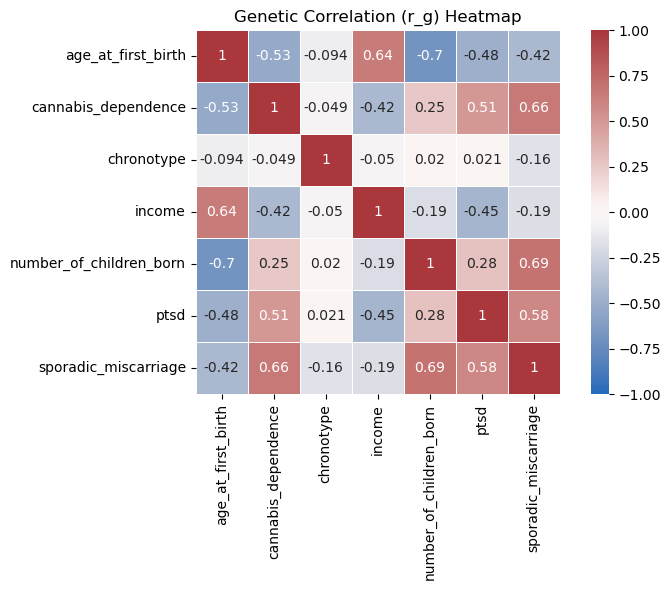

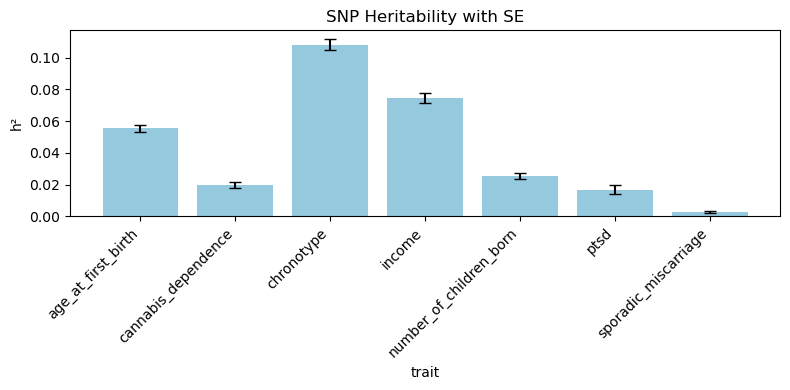

Available columns in estimates: ['lval', 'op', 'rval', 'Estimate', 'Std. Err', 'z-value', 'p-value']


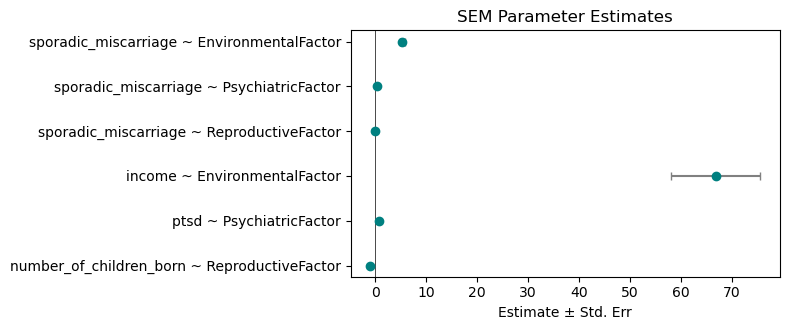

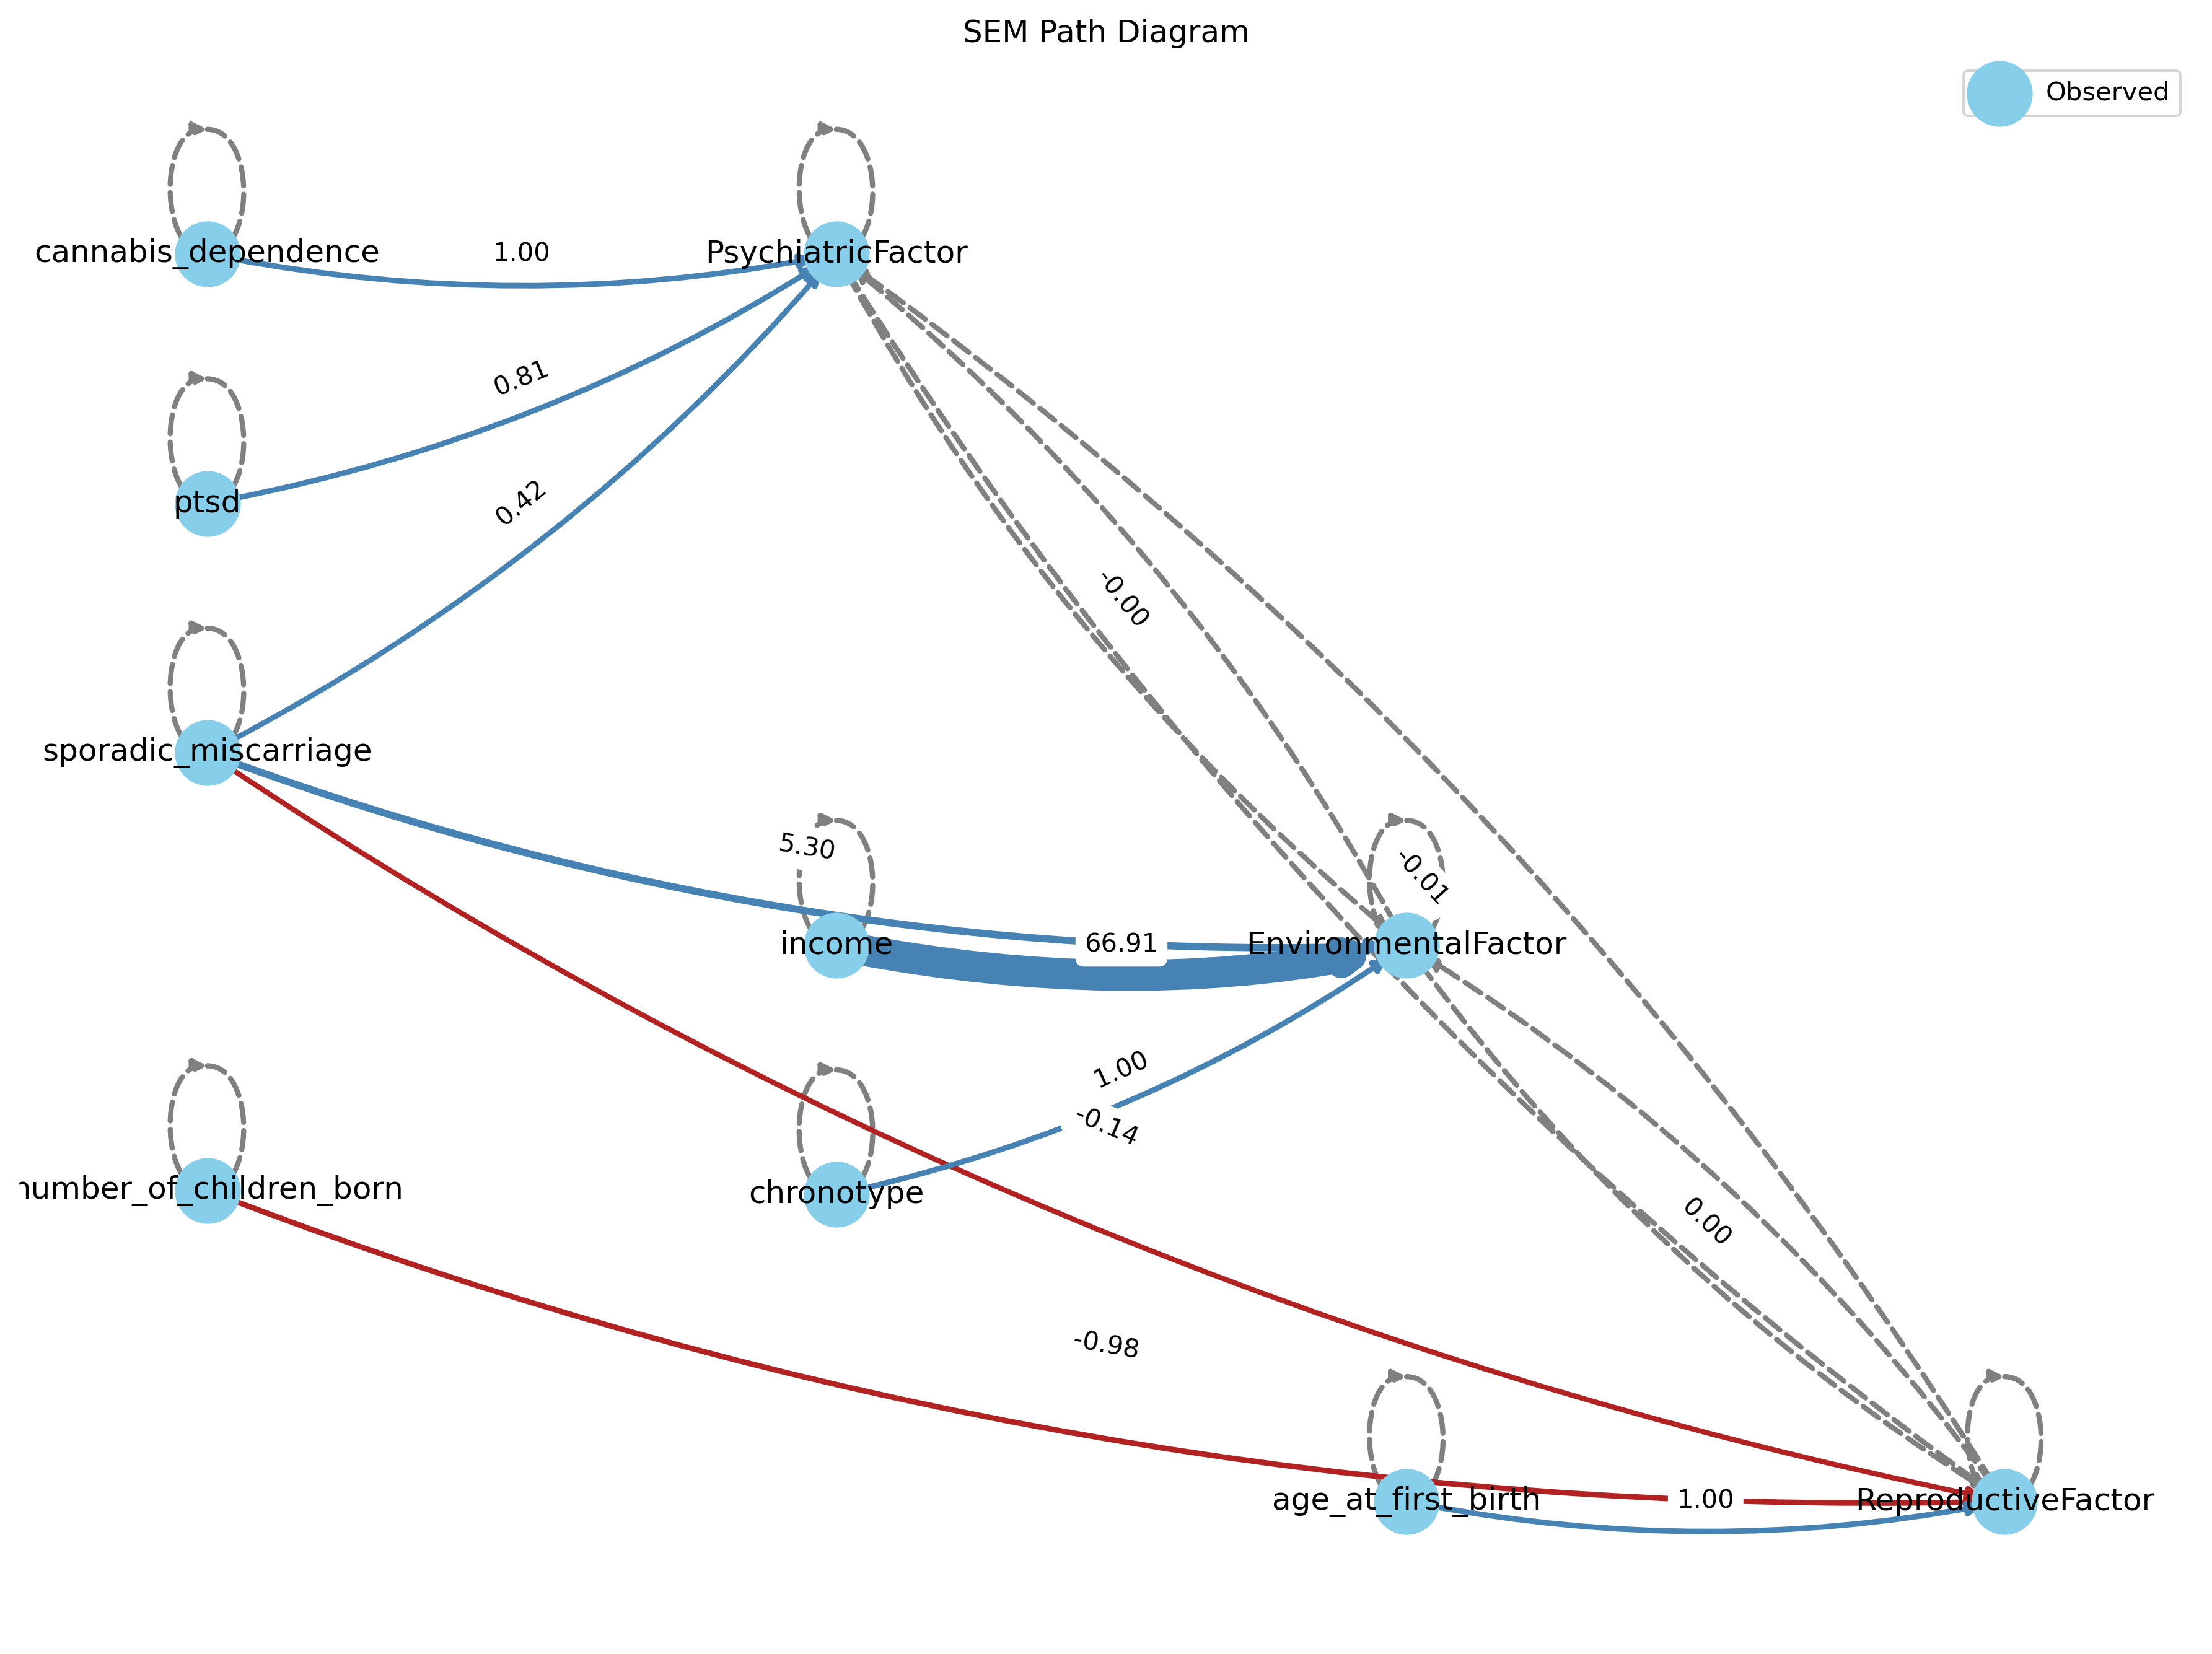

In [48]:
if __name__ == "__main__":
    model, SIGMA, estimates = run_gsem(traits, sample_size=1_000_000)
    gc_df = parse_genetic_correlation_results()
    h2_df = extract_heritability_results()

    plot_genetic_correlation(gc_df, traits)
    plot_h2(h2_df)
    plot_sem_parameters(estimates)
    #plot_sem_path_diagram(model)
    draw_sem_path_network(estimates=estimates)